# DLCV Assignment 1

**Due Date: 22/02/2024 11:59PM IST**

**Name:**     KANIKI BHIKSHAPATHI

**Sr. No.:**    24489


In this assignment, we will cover the following topics:

1) Training a simple Linear Model 

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used. 

# Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify an input $X_i$ of size $n$ into one of $m$ classes. For this, you need to consider the following:

1)  **Weight Matrix** $W_{n\times m}$: The Weights are multipled with the input $X_i$ (vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2)  **The Loss function**:   
  * The Cross Entropy Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $y_i$-th element of the output of $W^T  X_i$

3) **A Regularization term**: In addition to the loss, you need a Regularization term to lead to a more distributed (in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, with $L_2$ regularization, the loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2  
$$

Thus the total loss has the form:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

4) **An Optimization Procedure**: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:
$$
W_{t+1} = W_{t} - \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, with "mini-batch" gradient descent, instead of finding loss over the whole dataset, we use a small sample $B$ of the training data to make each learning step. Hence,
$$
W_{t+1} = W_{t} - \alpha \frac{\partial \sum_{i \in B}{L_{x_i}}}{\partial W},
$$
where $|B|$ is the batch size.

# Question 1

Train a **Single-Layer Classifier** for the MNIST dataset. 
* Use Softmax-Loss.
* Maintain a train-validation split of the original training set for finding the right value of $\lambda$ for the regularization, and to check for over-fitting.
* Finally, evaluate the classification performance on the test-set.


In [35]:
import numpy as np
import matplotlib.pyplot as plt


In [36]:
## Load The Mnist data:
# Download data from http://yann.lecun.com/exdb/mnist/
# load the data.
train_xx= np.load('train_data.npy')
train_yy= np.load('train_labels.npy')
test_xx= np.load('test_data.npy')
test_yy= np.load('test_labels.npy')

print(train_xx.shape)
print(train_yy.shape)
print(test_xx.shape)
print(test_yy.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [37]:
# maintain a train-val split
split = int(0.9 * len(train_xx))
train_x = train_xx[:split]
train_y = train_yy[:split]
valid_x = train_xx[split:]
valid_y = train_yy[split:]
#normalize the data
train_x = train_x / 255.0
valid_x = valid_x / 255.0
test_x = test_xx / 255.0



In [38]:

# Now, write a generator that yields (random) mini-batches of the input data
# Do not use same set of mini-batches for different epochs
    
def get_minibatch(training_x, training_y,batch_size=32):
    ## Read about Python generators if required.

    ## WRITE CODE HERE
    n = len(training_x)
    idx = np.random.permutation(n)
    for i in range(0, n, batch_size):
        yield training_x[idx[i:i + batch_size]], training_y[idx[i:i + batch_size]]
    

In [39]:
# Define the class for a Single Layer Classifier
class Single_layer_classifier():
    
    def __init__(self, input_size, output_size):
        
        ## WRITE CODE HERE
        
        # Give the instance a weight matrix, initialized randomly
        # The matrix should have dimensions (input_size, output_size)
        # The matrix should be stored as a torch tensor
        # The matrix should be initialized randomly
        # The matrix should be initialized with a normal distribution with mean 0 and standard deviation 1e-3
        
        self.W = np.random.randn(input_size, output_size) * 1e-3
        self.b = np.zeros(output_size)
        
        
        
    # Define the forward function
    def forward(self, input_x):
        
        # get the scores
        
        ## WRITE CODE HERE
        scores = np.dot(input_x, self.W) + self.b
        
        return scores
    
    # Similarly a backward function
    # we define 2 backward functions (as Loss = L_data + L_reg, grad(Loss) = grad(L1) + grad(L2))
    
    def backward_Ldata(self, grad_from_loss, input_x):
             # Transpose input_x to align dimensions for matrix multiplication
                grad_W = np.dot(input_x.T, grad_from_loss)  # input_x.T changes the shape from (256, 784) to (784, 256)
                grad_b = np.sum(grad_from_loss, axis=0)  # Sum over batch dimension for bias gradient

                return grad_W, grad_b

        
    def backward_Lreg(self,lamd_reg):
        
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the regularization-term
        # w.r.t. the corresponding element of W
        
        ## WRITE CODE HERE
        grad_matrix = 2 * self.W*lamd_reg
        return grad_matrix

In [40]:
# Implement the Softmax loss function
def loss_function(input_y, scores):

    ## WRITE CODE HERE    
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Compute the cross-entropy loss
    num_examples = input_y.shape[0]
    correct_logprobs = -np.log(probs[range(num_examples), input_y])
    loss = np.sum(correct_logprobs) / num_examples
    
    return loss, probs


def loss_backward(input_y, probs):
    # This part deals with the gradient of the loss w.r.t the output of network
    # for example, in case of softmax loss(-log(q_c)), this part gives grad(loss) w.r.t. q_c
    # pass this to backward_ldata

    ## WRITE CODE HERE    
    # num_examples = input_y.shape[0]
    
    # # Compute the gradient of the loss with respect to the scores
    ss = np.eye(10)[input_y]
    d_scores=probs-ss

    return d_scores
        

### Create utility functions for calculating training and validation accuracy

In [43]:
# WRITE CODE HERE

def calculate_accuracy(predictions, labels):

    return np.mean(predictions == labels)

def predict(scores):

    return np.argmax(scores, axis=1)


In [44]:
input_size = 28 * 28  # MNIST images are 28x28 pixels
output_size = 10  # There are 10 classes (digits 0-9)

In [45]:

def model_evaluation(train_x, train_y, valid_x, valid_y, testing_x, testing_y, t,lamd_reg,learning_rate,batch_size):            
        # Define input_size and output_size

        
        # Finally the trainer:
        # Make an instance of Single_layer_classifier
        # model = Single_layer_classifier(input_size, output_size)
        training_loss = []
        training_accuracy = []
        # Generate minibatches
        model = Single_layer_classifier(input_size, output_size)
        # Train for t epochs:
        for epoch in range(t):
            minibatch = get_minibatch(train_x, train_y, batch_size)
            avg_loss = 0
            avg_accuracy = 0
            count = 0
            for input_x, input_y in minibatch:
                
                scores = model.forward(input_x)
                loss, probs = loss_function(input_y, scores)
                grad_from_loss = loss_backward(input_y, probs)
                grad_W, grad_b = model.backward_Ldata(grad_from_loss, input_x)
                model.W -= learning_rate * (grad_W + model.backward_Lreg(lamd_reg))
                model.b -= learning_rate * grad_b
                
                predictions = predict(scores)
                train_accuracy = calculate_accuracy(predictions, input_y)
                avg_loss += loss
                avg_accuracy += train_accuracy
                count += 1
                # print(f'Epoch {epoch}, Training Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}')
            
            training_loss.append(avg_loss / count)
            training_accuracy.append(avg_accuracy / count)
            val_scores = model.forward(valid_x)
            val_predictions = predict(val_scores)
            val_accuracy = calculate_accuracy(val_predictions, valid_y)
            print(f'Epoch {epoch}, Validation Accuracy: {val_accuracy:.4f}')
        test_scores = model.forward(testing_x)
        test_predictions = predict(test_scores)
        test_accuracy = calculate_accuracy(test_predictions, testing_y)
        print(f'Test Accuracy: {test_accuracy:.4f}')
        return model , training_loss, training_accuracy, test_accuracy, val_accuracy

        

In [ ]:
model, training_loss, training_accuracy, test_accuracy, val_accuracy = model_evaluation(train_x, train_y, valid_x, valid_y, test_x, test_yy, 20, 0.01, 0.01, 32)


Epoch 0, Validation Accuracy: 0.9257
Epoch 1, Validation Accuracy: 0.9215
Epoch 2, Validation Accuracy: 0.9207
Epoch 3, Validation Accuracy: 0.9273
Epoch 4, Validation Accuracy: 0.9295
Epoch 5, Validation Accuracy: 0.9292
Epoch 6, Validation Accuracy: 0.9285
Epoch 7, Validation Accuracy: 0.9308
Epoch 8, Validation Accuracy: 0.9297
Epoch 9, Validation Accuracy: 0.9308
Test Accuracy: 0.9205


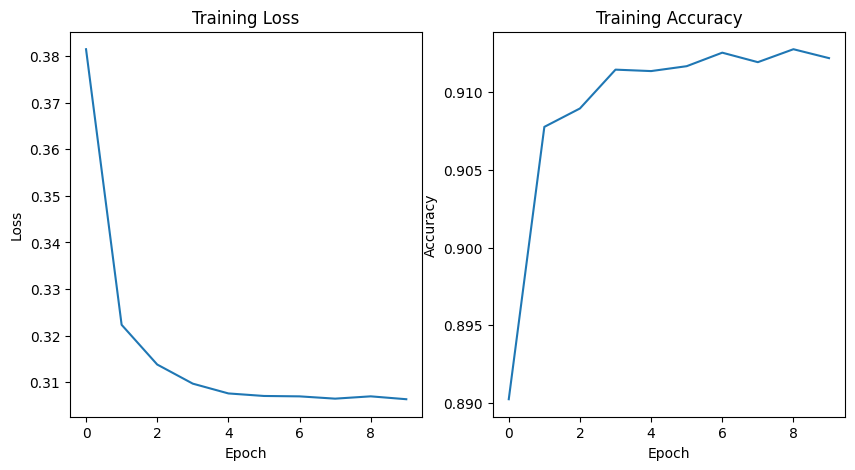

In [47]:
#plotting the training loss and training  accuracy  side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(training_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()



In [48]:
def evaluate_model(model, X, y):
    scores = model.forward(X)
    predictions = predict(scores)
    accuracy = calculate_accuracy(predictions, y)
    return accuracy

### Find the accuracy on the validation set

In [49]:

accuracy = evaluate_model(model, valid_x, valid_y)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.9308


# HYPERPARAMETER

In [53]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import ParameterGrid

# Define the parameter grid (only tuning learning_rate and regularization)
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'regularization': [0.001, 0.01, 0.1, 1],
    'batch_size': [32, 64, 128, 256],
    'epochs': [5,10, 20 ]
}
# Store results for visualization
results = []

# Grid search over hyperparameters
best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    _, training_loss, training_accuracy, test_accuracy, val_accuracy = model_evaluation(
        train_x, train_y, valid_x, valid_y, test_x, test_yy,
        t=params['epochs'],  # Fixed number of epochs
        lamd_reg=params['regularization'],
        learning_rate=params['learning_rate'],
        batch_size=params['batch_size']  # Fixed batch size
    )

    # Store results for visualization
    results.append({
        'learning_rate': params['learning_rate'],
        'regularization': params['regularization'],
        'epochs': params['epochs'],
        'batch_size': params['batch_size'],
        'training_loss': training_loss,
        'training_accuracy': training_accuracy,
        'validation_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
        
    })

    # Update best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

# Convert results to DataFrame
results_df = pd.DataFrame(results)

Training with parameters: {'batch_size': 32, 'epochs': 5, 'learning_rate': 0.001, 'regularization': 0.001}
Epoch 0, Validation Accuracy: 0.9135
Epoch 1, Validation Accuracy: 0.9250
Epoch 2, Validation Accuracy: 0.9263
Epoch 3, Validation Accuracy: 0.9255
Epoch 4, Validation Accuracy: 0.9293
Test Accuracy: 0.9183
Training with parameters: {'batch_size': 32, 'epochs': 5, 'learning_rate': 0.001, 'regularization': 0.01}
Epoch 0, Validation Accuracy: 0.9147
Epoch 1, Validation Accuracy: 0.9228
Epoch 2, Validation Accuracy: 0.9272
Epoch 3, Validation Accuracy: 0.9255
Epoch 4, Validation Accuracy: 0.9287
Test Accuracy: 0.9175
Training with parameters: {'batch_size': 32, 'epochs': 5, 'learning_rate': 0.001, 'regularization': 0.1}
Epoch 0, Validation Accuracy: 0.9138
Epoch 1, Validation Accuracy: 0.9183
Epoch 2, Validation Accuracy: 0.9217
Epoch 3, Validation Accuracy: 0.9197
Epoch 4, Validation Accuracy: 0.9235
Test Accuracy: 0.9118
Training with parameters: {'batch_size': 32, 'epochs': 5, 'le

C:\Users\New Fly High\AppData\Local\Temp\ipykernel_43132\1405079371.py:10: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[range(num_examples), input_y])


Epoch 0, Validation Accuracy: 0.3295
Epoch 1, Validation Accuracy: 0.3652
Epoch 2, Validation Accuracy: 0.4457
Epoch 3, Validation Accuracy: 0.3102
Epoch 4, Validation Accuracy: 0.4717
Test Accuracy: 0.4732
Training with parameters: {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.001, 'regularization': 0.001}
Epoch 0, Validation Accuracy: 0.9145
Epoch 1, Validation Accuracy: 0.9223
Epoch 2, Validation Accuracy: 0.9268
Epoch 3, Validation Accuracy: 0.9265
Epoch 4, Validation Accuracy: 0.9295
Epoch 5, Validation Accuracy: 0.9292
Epoch 6, Validation Accuracy: 0.9312
Epoch 7, Validation Accuracy: 0.9327
Epoch 8, Validation Accuracy: 0.9322
Epoch 9, Validation Accuracy: 0.9317
Test Accuracy: 0.9210
Training with parameters: {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.001, 'regularization': 0.01}
Epoch 0, Validation Accuracy: 0.9138
Epoch 1, Validation Accuracy: 0.9222
Epoch 2, Validation Accuracy: 0.9253
Epoch 3, Validation Accuracy: 0.9285
Epoch 4, Validation Accuracy: 0.9305

In [54]:
print("\nBest Parameters Found:")
print(best_params)


Best Parameters Found:
{'batch_size': 256, 'epochs': 20, 'learning_rate': 0.001, 'regularization': 0.001}


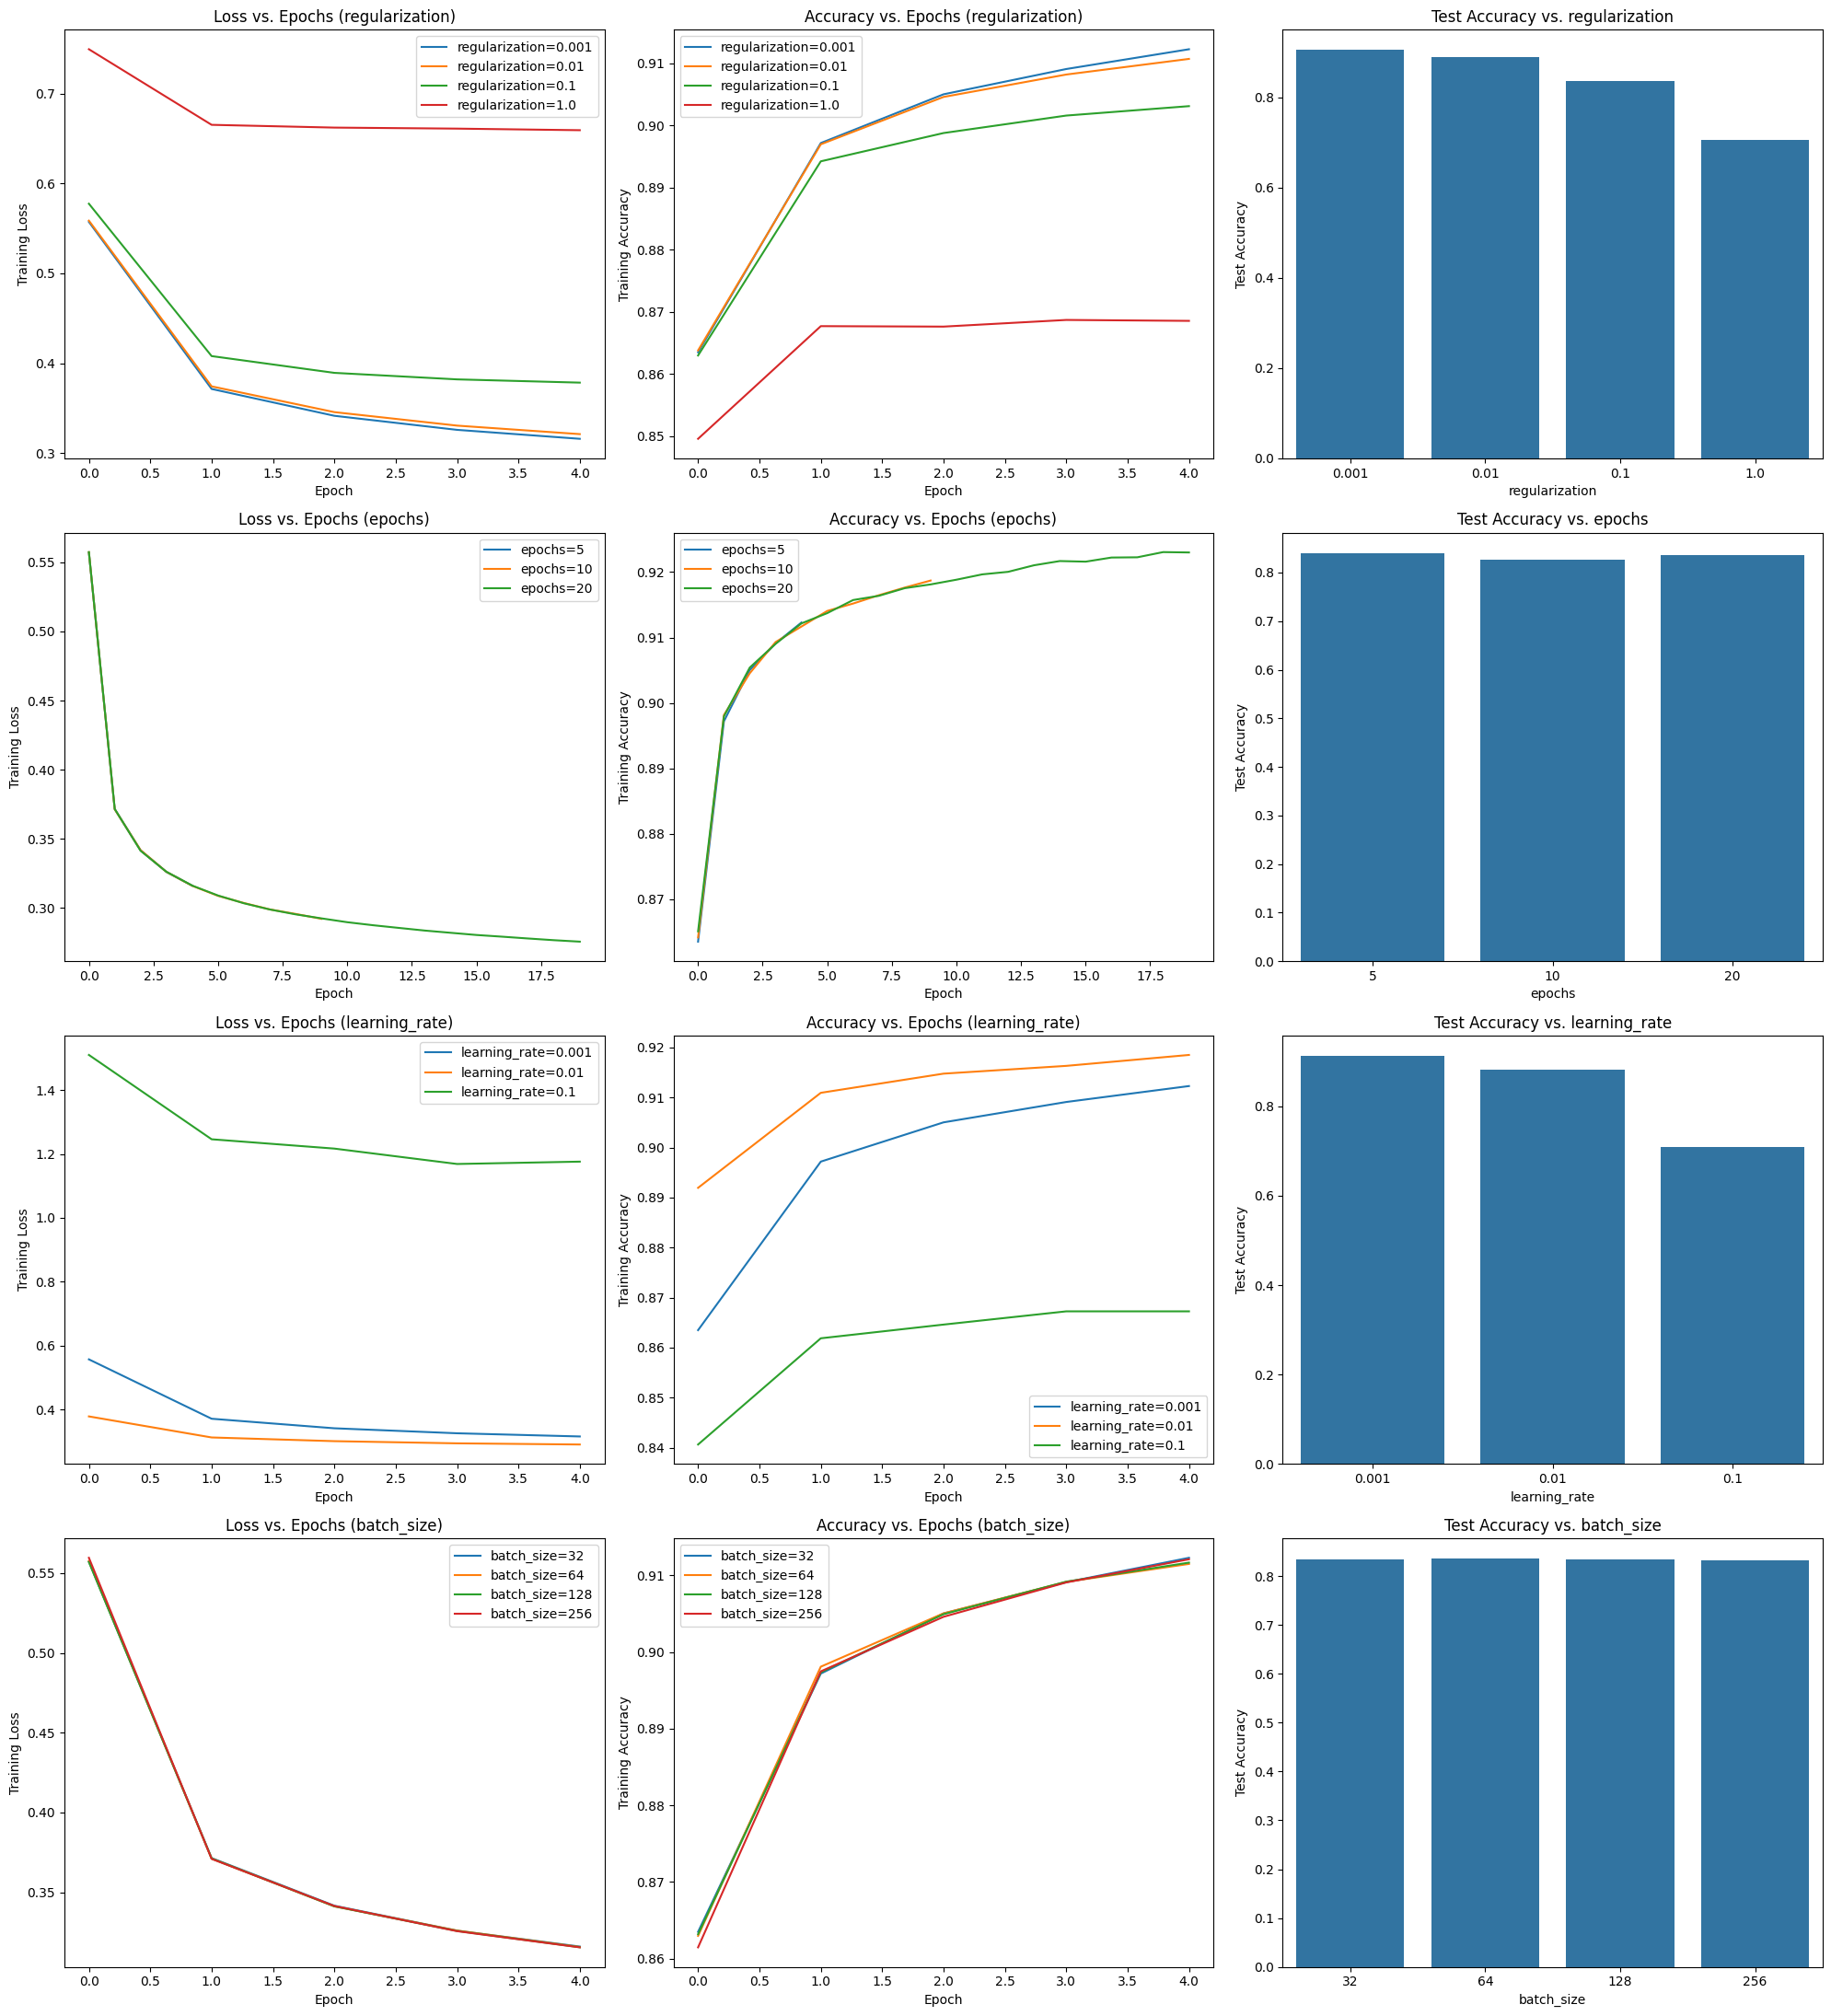

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_vs_epochs(df, hyperparam, ax_loss, ax_acc):

    unique_vals = sorted(df[hyperparam].unique())
    
    for val in unique_vals:
        # Filter to rows with this hyperparam value
        sub_df = df[df[hyperparam] == val]
        
        # If multiple rows share the same hyperparam (because of other params),
        # you can either plot them all or pick one. Below we just pick the first for simplicity.
        row = sub_df.iloc[0]
        
        loss_list = row['training_loss']      # e.g., list of length = number of epochs
        acc_list  = row['training_accuracy']  # same length as loss_list
        
        ax_loss.plot(range(len(loss_list)), loss_list, label=f"{hyperparam}={val}")
        ax_acc.plot(range(len(acc_list)), acc_list, label=f"{hyperparam}={val}")
    
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Training Loss")
    ax_loss.legend()
    
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Training Accuracy")
    ax_acc.legend()


def plot_test_accuracy(df, hyperparam, ax_bar):

    grouped = df.groupby(hyperparam)['test_accuracy'].mean().reset_index()
    
    sns.barplot(data=grouped, x=hyperparam, y='test_accuracy', ax=ax_bar)
    ax_bar.set_ylabel("Test Accuracy")
    ax_bar.set_title(f"Test Accuracy vs. {hyperparam}")

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 22))

# Row 0: regularization
plot_metric_vs_epochs(results_df, 'regularization', axes[0,0], axes[0,1])
axes[0,0].set_title("Loss vs. Epochs (regularization)")
axes[0,1].set_title("Accuracy vs. Epochs (regularization)")
plot_test_accuracy(results_df, 'regularization', axes[0,2])

# Row 1: epochs
plot_metric_vs_epochs(results_df, 'epochs', axes[1,0], axes[1,1])
axes[1,0].set_title("Loss vs. Epochs (epochs)")
axes[1,1].set_title("Accuracy vs. Epochs (epochs)")
plot_test_accuracy(results_df, 'epochs', axes[1,2])

# Row 2: learning_rate
plot_metric_vs_epochs(results_df, 'learning_rate', axes[2,0], axes[2,1])
axes[2,0].set_title("Loss vs. Epochs (learning_rate)")
axes[2,1].set_title("Accuracy vs. Epochs (learning_rate)")
plot_test_accuracy(results_df, 'learning_rate', axes[2,2])

# Row 3: batch_size
plot_metric_vs_epochs(results_df, 'batch_size', axes[3,0], axes[3,1])
axes[3,0].set_title("Loss vs. Epochs (batch_size)")
axes[3,1].set_title("Accuracy vs. Epochs (batch_size)")
plot_test_accuracy(results_df, 'batch_size', axes[3,2])

plt.tight_layout()
plt.show()


### Report final performance on MNIST test set

In [65]:
# WRITE CODE HERE
model, training_loss, training_accuracy, test_accuracy, val_accuracy = model_evaluation(train_x, train_y, valid_x, valid_y, test_x, test_yy, 20, 0.01, 0.01, 32)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Epoch 0, Validation Accuracy: 0.9227
Epoch 1, Validation Accuracy: 0.9218
Epoch 2, Validation Accuracy: 0.9278
Epoch 3, Validation Accuracy: 0.9260
Epoch 4, Validation Accuracy: 0.9278
Epoch 5, Validation Accuracy: 0.9268
Epoch 6, Validation Accuracy: 0.9280
Epoch 7, Validation Accuracy: 0.9245
Epoch 8, Validation Accuracy: 0.9267
Epoch 9, Validation Accuracy: 0.9210
Epoch 10, Validation Accuracy: 0.9257
Epoch 11, Validation Accuracy: 0.9240
Epoch 12, Validation Accuracy: 0.9270
Epoch 13, Validation Accuracy: 0.9167
Epoch 14, Validation Accuracy: 0.9275
Epoch 15, Validation Accuracy: 0.9298
Epoch 16, Validation Accuracy: 0.9222
Epoch 17, Validation Accuracy: 0.9272
Epoch 18, Validation Accuracy: 0.9270
Epoch 19, Validation Accuracy: 0.9227
Test Accuracy: 0.9103
Test Accuracy: 0.9103
Validation Accuracy: 0.9227


### Find the best performing class and the worst performing class

In [66]:
# WRITE CODE HERE
#divide the data into label wise  on test  data
label_wise_data = {}
for i in range(10):
    label_wise_data[i] = test_x[test_yy == i]

label_wise_predictions = {}
label_wise_accuracies = {}
for key, value in label_wise_data.items():
    scores = model.forward(value)
    predictions = predict(scores)
    label_wise_predictions[key] = predictions
    label_wise_accuracies[key] = calculate_accuracy(predictions, np.full(predictions.shape, key))
#print the accuracies
print(label_wise_accuracies)

#print max and min accuracies class and their accuracies
max_accuracy = max(label_wise_accuracies, key=label_wise_accuracies.get)
min_accuracy = min(label_wise_accuracies, key=label_wise_accuracies.get)
print(f'Maximum accuracy class: {max_accuracy}, Accuracy: {label_wise_accuracies[max_accuracy]:.4f}')
print(f'Minimum accuracy class: {min_accuracy}, Accuracy: {label_wise_accuracies[min_accuracy]:.4f}')

 

{0: np.float64(0.976530612244898), 1: np.float64(0.9850220264317181), 2: np.float64(0.9098837209302325), 3: np.float64(0.8306930693069307), 4: np.float64(0.9470468431771895), 5: np.float64(0.9159192825112108), 6: np.float64(0.94258872651357), 7: np.float64(0.9056420233463035), 8: np.float64(0.8357289527720739), 9: np.float64(0.8473736372646185)}
Maximum accuracy class: 1, Accuracy: 0.9850
Minimum accuracy class: 3, Accuracy: 0.8307


# Training a Linear Classifier on MNIST from scikit-learn

In this section you have to train a linear classifier from the scikit-learn library and compare its results against your implementation.
(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [67]:
    # WRITE CODE HERE 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Initialize and train the logistic regression model
# Note: We use lbfgs solver and increase `max_iter` as the default may not converge.
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
logistic_model.fit(train_x, train_y)




c:\Users\New Fly High\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

### Compare the training and test accuracies for the your implementation and linear classifier from scikit-learn

In [68]:
    # WRITE CODE HERE

train_accuracy_lr = logistic_model.score(train_x, train_y)
test_accuracy_lr = logistic_model.score(test_x, test_yy)

# Evaluate custom model
train_accuracy_custom = evaluate_model(model, train_x, train_y)
test_accuracy_custom = evaluate_model(model, test_x, test_yy)

# # Print the results
print(f"Logistic Regression Model - Training Accuracy: {train_accuracy_lr:.2f}, Testing Accuracy: {test_accuracy_lr:.2f}")
print(f"Custom Model - Training Accuracy: {train_accuracy_custom:.2f}, Testing Accuracy: {test_accuracy_custom:.2f}")

Logistic Regression Model - Training Accuracy: 0.94, Testing Accuracy: 0.92
Custom Model - Training Accuracy: 0.91, Testing Accuracy: 0.91


### Any additional observations / comments?

# HyperParameter Tuning:
  It was evident that good learning and regularization term both contribute significant effect on the training Model on  Minst dataset.
  The  smaller learning rate enhances model to reach minimum loss ,that  very high leaning rate ,since high learning rae may sometime causes jump from the local minima while otimizing the loss function.

  Batch size and no of echoes are not contibuting significantly effect on the loss function, because for most of the parameter it reamians same.




## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

In [79]:
# WRITE CODE HERE
train_split=[0.1,0.2,0.5]
results=[]
for i in train_split:
    split = int(i * len(train_xx))
    train_x = train_xx[:split]
    train_y = train_yy[:split]
    valid_x = train_xx[split:]
    valid_y = train_yy[split:]
    _, training_loss, training_accuracy, test_accuracy, val_accuracy = model_evaluation(train_x, train_y, valid_x, valid_y, test_x, test_yy, 20, 0.01, 0.01, 32)
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    results.append({
        'train_split': i,
        'training_loss': training_loss,
        'training_accuracy': training_accuracy,
        'validation_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
        
    })
    
    




C:\Users\New Fly High\AppData\Local\Temp\ipykernel_43132\1405079371.py:10: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[range(num_examples), input_y])


Epoch 0, Validation Accuracy: 0.7947
Epoch 1, Validation Accuracy: 0.8216
Epoch 2, Validation Accuracy: 0.8461
Epoch 3, Validation Accuracy: 0.8741
Epoch 4, Validation Accuracy: 0.8513
Epoch 5, Validation Accuracy: 0.8541
Epoch 6, Validation Accuracy: 0.8232
Epoch 7, Validation Accuracy: 0.8634
Epoch 8, Validation Accuracy: 0.8470
Epoch 9, Validation Accuracy: 0.8556
Epoch 10, Validation Accuracy: 0.8597
Epoch 11, Validation Accuracy: 0.8534
Epoch 12, Validation Accuracy: 0.8643
Epoch 13, Validation Accuracy: 0.8599
Epoch 14, Validation Accuracy: 0.8636
Epoch 15, Validation Accuracy: 0.8482
Epoch 16, Validation Accuracy: 0.8619
Epoch 17, Validation Accuracy: 0.8402
Epoch 18, Validation Accuracy: 0.8575
Epoch 19, Validation Accuracy: 0.8570
Test Accuracy: 0.8636
Test Accuracy: 0.8636
Validation Accuracy: 0.8570
Epoch 0, Validation Accuracy: 0.8526
Epoch 1, Validation Accuracy: 0.8625
Epoch 2, Validation Accuracy: 0.8526
Epoch 3, Validation Accuracy: 0.8728
Epoch 4, Validation Accuracy: 

# Implementing Backpropagation

Now that you have had some experience with single layer networks, we can proceed to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simply put, a way of computing gradients of expressions through repeated application of chain rule. If
$$
L = f (g (h (\textbf{x})))
$$
then, by the chain rule we have:
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial \textbf{x}} 
$$

** Look into the class Lecture for more detail **



# Question 2 : Scalar Backpropagation

Evaluate the gradient of the following function w.r.t. the input:

$$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times x)+sin(\pi \times y/2)}{tanh(z^2)}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following inputs:
  * $(x,y,z)$ =  (2,4,1)
  * $(x,y,z)$ =  (9,14,3)
  * $(x,y,z)$ =  (128,42,666)
  * $(x,y,z)$ =  (52,14,28)

      

In [119]:

# Define the basic operations as classes
class Cosine:
    def forward(self, x):
        self.x = x
        return np.cos(np.pi * x)
    
    def backward(self, grad_output):
         # self is not fractional then return 0
        return -np.pi * np.sin(np.pi * self.x) * grad_output

class Sine:
    def forward(self, y):
        self.y = y
        return np.sin(np.pi * y / 2)
    
    def backward(self, grad_output):
        return (np.pi / 2) * np.cos(np.pi * self.y / 2) * grad_output

class Tanh:
    def forward(self, z):
        self.z = z
        self.output = np.tanh(self.z ** 2)
        return self.output
    
    def backward(self, grad_output):
        return 2 * self.z * (1 - self.output ** 2) * grad_output  # Fixed

class Sigmoid:
    def forward(self, t):
        self.t = t
        self.output = 1 / (1 + np.exp(-t))
        return self.output
    
    def backward(self, grad_output):
        return self.output * (1 - self.output) * grad_output

class Log:
    def forward(self, sigma):
        self.sigma = sigma
        return np.log(sigma)
    
    def backward(self, grad_output):
        return grad_output / self.sigma

# Combine them in the functional form
class Func:
    def __init__(self):
        self.cos = Cosine()
        self.sin = Sine()
        self.tanh = Tanh()
        self.sigmoid = Sigmoid()
        self.log = Log()
        
    def forward(self, x, y, z):
        self.u = self.cos.forward(x)
        self.v = self.sin.forward(y)
        self.w = self.tanh.forward(z)
        self.t = (self.u + self.v) / self.w
        self.s = self.sigmoid.forward(self.t)
        output = self.log.forward(self.s)
        return output
    
    def backward(self, grad_output=1):
        grad_log = self.log.backward(grad_output)
        grad_sigmoid = self.sigmoid.backward(grad_log)

        # Correcting the gradient flow
        grad_t = grad_sigmoid / self.w  
        grad_cos = self.cos.backward(grad_t)
        grad_sin = self.sin.backward(grad_t)
        grad_tanh = self.tanh.backward(-((self.u + self.v) / self.w**2) * grad_sigmoid)

        return [grad_cos, grad_sin, grad_tanh]

# Usage
func = Func()
points = [(2, 4, 1), (9, 14, 3), (128, 42, 666), (52, 14, 28)]
gradients = []

for x, y, z in points:
    f_val = func.forward(x, y, z)
    grads = func.backward()
    gradients.append((x, y, z, grads))

for point, grad in zip(points, gradients):
    print(f"Gradients at (x={point[0]}, y={point[1]}, z={point[2]}) are: dx={grad[3][0]}, dy={grad[3][1]}, dz={grad[3][2]}")


Gradients at (x=2, y=4, z=1) are: dx=2.1417102890343505e-16, dy=0.43720979194276516, dz=-0.3069722756588883
Gradients at (x=9, y=14, z=3) are: dx=-2.5313688314302287e-15, dy=-1.148344174369598, dz=2.672161875217988e-07
Gradients at (x=128, y=42, z=666) are: dx=1.3244281103803983e-14, dy=-0.42245219681098717, dz=-0.0
Gradients at (x=52, y=14, z=28) are: dx=-6.6263243875773434e-15, dy=-0.42245219681098645, dz=-0.0


## Question 3 : Modular Vector Backpropagation

* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set, MNIST, with the same train-val split.

In [83]:
train_xx= np.load('train_data.npy')
train_yy= np.load('train_labels.npy')
test_xx= np.load('test_data.npy')
test_yy= np.load('test_labels.npy')
split = int(0.9 * len(train_xx))
train_x = train_xx[:split]
train_y = train_yy[:split]
valid_x = train_xx[split:]
valid_y = train_yy[split:]
#normalize the data
train_x = train_x / 255.0
valid_x = valid_x / 255.0
test_x = test_xx / 255.0


In [84]:

class LinearLayer:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))

    def forward(self, input_x):
        return np.dot(input_x, self.W) + self.b

    def backward(self, input_x, grad_output):
        grad_W = np.dot(input_x.T, grad_output)
        grad_b = np.sum(grad_output, axis=0, keepdims=True)
        grad_input = np.dot(grad_output, self.W.T)
        return grad_input, grad_W, grad_b

    def update_params(self, grad_W, grad_b, learning_rate):
        self.W -= learning_rate * grad_W
        self.b -= learning_rate * grad_b


In [85]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

In [86]:
num_classes = 10  # MNIST has 10 classes for digits 0-9
train_y = one_hot_encode(train_y, num_classes)
valid_y = one_hot_encode(valid_y, num_classes)
test_yy = one_hot_encode(test_yy, num_classes)


In [87]:
input_size = 784
hidden_size = 100
output_size = 10

In [88]:
class ReLU:
    def forward(self, input_x):
        self.mask = (input_x > 0)
        return input_x * self.mask
    
    def backward(self, grad_output):
        return grad_output * self.mask


In [89]:
class TwoLayerMLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.layer1 = LinearLayer(input_size, hidden_size)
        self.relu = ReLU()
        self.layer2 = LinearLayer(hidden_size, output_size)
    
    def forward(self, input_x):
        out1 = self.layer1.forward(input_x)
        out2 = self.relu.forward(out1)
        out3 = self.layer2.forward(out2)
        return out3
    
    def backward(self, input_x, grad_output):
        grad2, grad_W2, grad_b2 = self.layer2.backward(self.relu.forward(self.layer1.forward(input_x)), grad_output)
        grad1_relu = self.relu.backward(grad2)
        grad1, grad_W1, grad_b1 = self.layer1.backward(input_x, grad1_relu)
        return (grad_W1, grad_b1), (grad_W2, grad_b2)

In [90]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

def cross_entropy(predictions, targets):
    predictions = softmax(predictions)
    return -np.mean(np.sum(targets * np.log(predictions + 1e-9), axis=1))

def compute_grad_from_loss(predictions, targets):
    predictions = softmax(predictions)
    return predictions - targets

def calculate_accuracy(predictions, labels):
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    return np.mean(pred_labels == true_labels)


In [91]:
def train( train_data, train_labels, valid_x, valid_y, epochs, learning_rate, batch_size=100):
    traing_loss=[]
    trianing_accuracy=[]
    model = TwoLayerMLP(input_size, hidden_size, output_size)
    for epoch in range(epochs):
        # Shuffle training data
        minibatches = get_minibatch(train_data, train_labels, batch_size)
        avg_loss = 0
        avg_accuracy = 0
        count = 0
        for batch_x, batch_y in minibatches:

            # Forward pass
            output = model.forward(batch_x)
            # Compute loss
            loss = cross_entropy(output, batch_y)
            # Backward pass
            grad_output = compute_grad_from_loss(output, batch_y)
            grads = model.backward(batch_x, grad_output)
            predictions=softmax(output)
            acuracy = calculate_accuracy(predictions, batch_y)
            avg_loss += loss
            avg_accuracy += acuracy
            count += 1

            # Update model parameters
            model.layer1.update_params(*grads[0], learning_rate)
            model.layer2.update_params(*grads[1], learning_rate)

        # Validation step
        traing_loss.append(avg_loss / count)
        trianing_accuracy.append(avg_accuracy / count)
        
        val_predictions = model.forward(valid_x)

        val_loss = cross_entropy(val_predictions, valid_y)
        val_accuracy = calculate_accuracy(val_predictions, valid_y)

        print(f"Epoch {epoch+1}: Loss = {loss}, Validation Loss = {val_loss}, Accuracy = {val_accuracy}")
        
    return model,traing_loss, trianing_accuracy, val_loss, val_accuracy



In [92]:
# Train the model
epochs = 10
learning_rate = 0.01

model,traing_loss, trianing_accuracy, val_loss, val_accuracy= train( train_x, train_y, valid_x, valid_y, epochs, learning_rate)


Epoch 1: Loss = 0.16223861158611388, Validation Loss = 0.13631060921234867, Accuracy = 0.9596666666666667
Epoch 2: Loss = 0.14319044832701364, Validation Loss = 0.09369230042056832, Accuracy = 0.9726666666666667
Epoch 3: Loss = 0.03459594263558129, Validation Loss = 0.08585601000956664, Accuracy = 0.9751666666666666
Epoch 4: Loss = 0.08973108922012278, Validation Loss = 0.08269605476020972, Accuracy = 0.9748333333333333
Epoch 5: Loss = 0.13029221724016263, Validation Loss = 0.09528242760587659, Accuracy = 0.9728333333333333
Epoch 6: Loss = 0.04451871701357984, Validation Loss = 0.09306402523380541, Accuracy = 0.9725
Epoch 7: Loss = 0.012788540082853024, Validation Loss = 0.08572918048602783, Accuracy = 0.978
Epoch 8: Loss = 0.032823374428134856, Validation Loss = 0.07666397270940627, Accuracy = 0.9791666666666666
Epoch 9: Loss = 0.01885959610232687, Validation Loss = 0.07792689849283352, Accuracy = 0.9776666666666667
Epoch 10: Loss = 0.006473970737159864, Validation Loss = 0.0882570844

### Plot the training loss and training accuracy plot

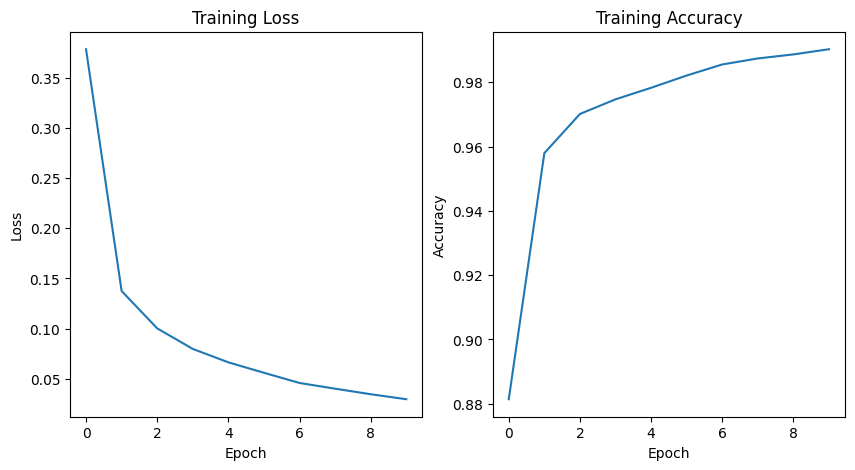

In [93]:
# Use the same utility functions defined in the previous question
# WRITE CODE HERE
#plotting the training loss and training  accuracy  side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(traing_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(trianing_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


### Find the accuracy on the validation set

In [94]:
# WRITE CODE HERE
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 0.0883
Validation Accuracy: 0.9767


In [ ]:
# Find the optimal value of learning rate and batch size. 
# Use the same tuning strategy as the previous question
# Create plot and table to show the effect of the hparams.


import seaborn as sns
import pandas as pd
from sklearn.model_selection import ParameterGrid

# Define the parameter grid (only tuning learning_rate and regularization)
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128, 256],
}
# Store results for visualization
results = []

# Grid search over hyperparameters
best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    _,training_loss, training_accuracy, val_loss, val_accuracy = train(
train_x, train_y, valid_x, valid_y, 10, params['learning_rate'], params['batch_size'])

    # Store results for visualization
    results.append({
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'training_loss': training_loss,
        'training_accuracy': training_accuracy,
        'validation_accuracy': val_accuracy,
        'validation_loss': val_loss
    })

    # Update best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display best hyperparameters
print("\nBest Parameters Found:")
print(best_params)

#plot test accuracy
def plot_metric_vs_epochs(df, hyperparam, ax_loss, ax_acc):

    unique_vals = sorted(df[hyperparam].unique())
    
    for val in unique_vals:
        # Filter to rows with this hyperparam value
        sub_df = df[df[hyperparam] == val]
        
        # If multiple rows share the same hyperparam (because of other params),
        # you can either plot them all or pick one. Below we just pick the first for simplicity.
        row = sub_df.iloc[0]
        
        loss_list = row['training_loss']      # e.g., list of length = number of epochs
        acc_list  = row['training_accuracy']  # same length as loss_list
        
        ax_loss.plot(range(len(loss_list)), loss_list, label=f"{hyperparam}={val}")
        ax_acc.plot(range(len(acc_list)), acc_list, label=f"{hyperparam}={val}")
    
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Training Loss")
    ax_loss.legend()
    
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Training Accuracy")
    ax_acc.legend()


Training with parameters: {'batch_size': 32, 'learning_rate': 0.001}
Epoch 1: Loss = 0.30170108923970035, Validation Loss = 0.2841117026122539, Accuracy = 0.9211666666666667
Epoch 2: Loss = 0.2638770468035201, Validation Loss = 0.2233060745662872, Accuracy = 0.9363333333333334
Epoch 3: Loss = 0.10101035089300983, Validation Loss = 0.18505357200359246, Accuracy = 0.9516666666666667
Epoch 4: Loss = 0.22959092354955657, Validation Loss = 0.16219096939536418, Accuracy = 0.9575
Epoch 5: Loss = 0.17903761723345096, Validation Loss = 0.14975915571259962, Accuracy = 0.9605
Epoch 6: Loss = 0.32068058216987805, Validation Loss = 0.13113049520674017, Accuracy = 0.9653333333333334
Epoch 7: Loss = 0.07009403193360697, Validation Loss = 0.12283560287225177, Accuracy = 0.9675
Epoch 8: Loss = 0.1314813382482694, Validation Loss = 0.11202922445786055, Accuracy = 0.9703333333333334
Epoch 9: Loss = 0.10678740526069441, Validation Loss = 0.10711491076976222, Accuracy = 0.9718333333333333
Epoch 10: Loss = 

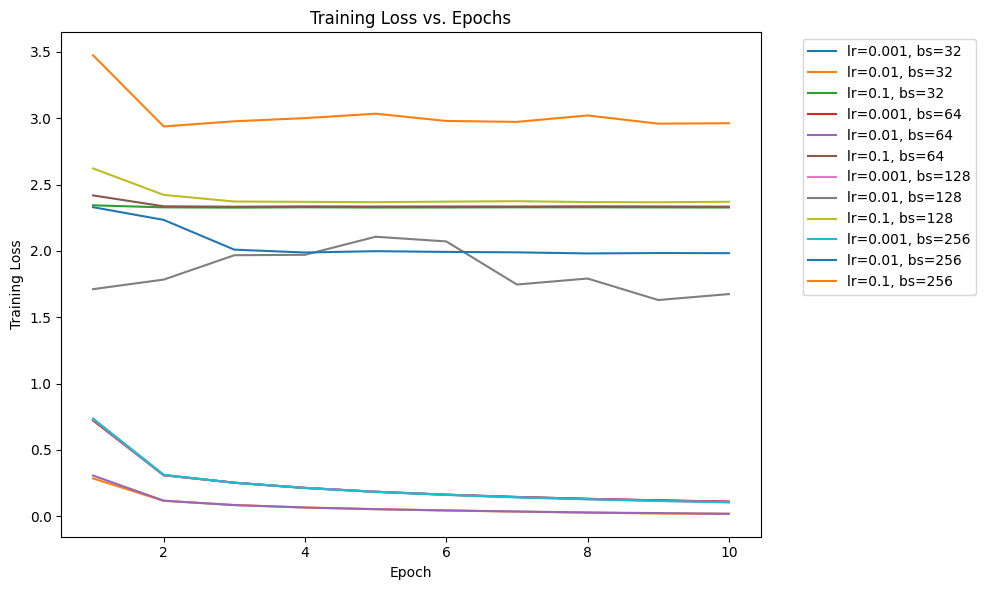

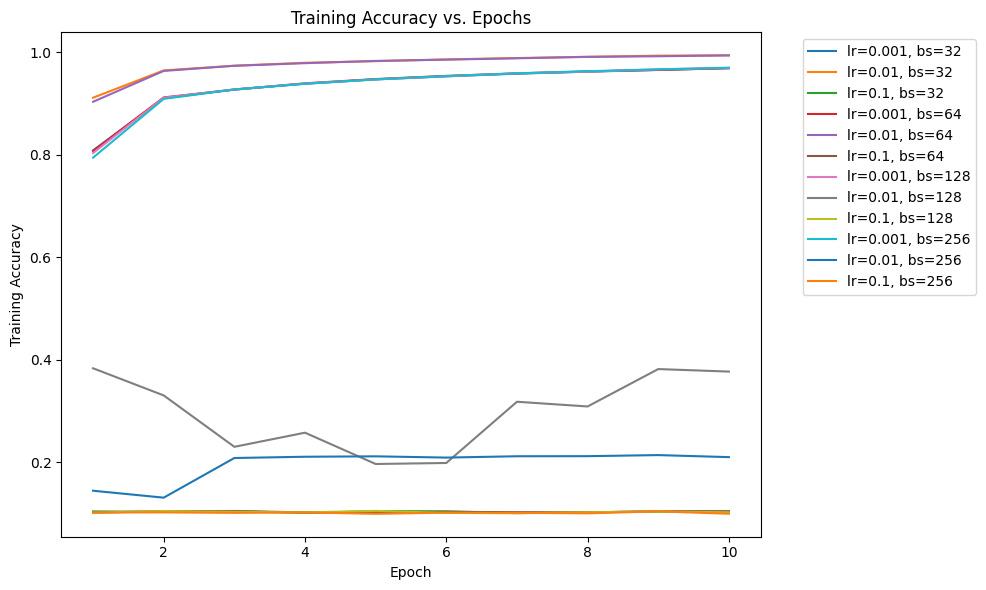

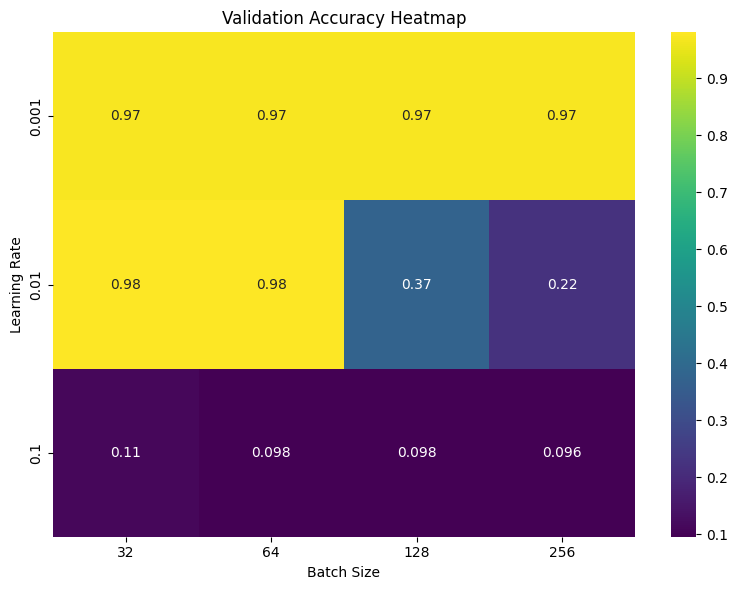

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Plot 1: Training Loss vs. Epochs
# ----------------------------
plt.figure(figsize=(10, 6))
for idx, row in results_df.iterrows():
    # Create an epoch list starting at 1 up to the length of training_loss
    epochs = list(range(1, len(row['training_loss']) + 1))
    # Label for the line: show learning rate and batch size
    label = f"lr={row['learning_rate']}, bs={row['batch_size']}"
    plt.plot(epochs, row['training_loss'], label=label)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2: Training Accuracy vs. Epochs
# ----------------------------
plt.figure(figsize=(10, 6))
for idx, row in results_df.iterrows():
    epochs = list(range(1, len(row['training_accuracy']) + 1))
    label = f"lr={row['learning_rate']}, bs={row['batch_size']}"
    plt.plot(epochs, row['training_accuracy'], label=label)

plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs. Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----------------------------
# Plot 3: Validation Accuracy Heatmap
# ----------------------------
# Create a pivot table where rows are learning_rate, columns are batch_size, and values are validation_accuracy
pivot_val_acc = results_df.pivot(index='learning_rate', columns='batch_size', values='validation_accuracy')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_val_acc, annot=True, cmap="viridis")
plt.title("Validation Accuracy Heatmap")
plt.xlabel("Batch Size")
plt.ylabel("Learning Rate")
plt.tight_layout()
plt.show()


### Report final performance on MNIST test set

In [ ]:
# WRITE CODE HERE
model,_,_,_,_ = train(train_x, train_y, valid_x, valid_y, 10, 0.01,32)


Epoch 1: Loss = 0.13592551185635413, Validation Loss = 0.11789182560676371, Accuracy = 0.9675
Epoch 2: Loss = 0.18517910167231036, Validation Loss = 0.08896211162499365, Accuracy = 0.9746666666666667


In [39]:
test_predictions = model.forward(test_x)
print(test_predictions.shape)
print(test_yy.shape)
test_accuracy = calculate_accuracy(test_predictions, test_yy)

print(f'Test Accuracy: {test_accuracy:.4f}')

(10000, 10)
(10000, 10)
Test Accuracy: 0.9692


### Find the best performing class and the worst performing class

In [110]:
# WRITE CODE HERE
#divide the data into label wise on test data
label_wise_data = {}
for i in range(10):
    label_wise_data[i] = test_x[np.argmax(test_yy, axis=1) == i]

label_wise_predictions = {}
label_wise_accuracies = {}

for key, value in label_wise_data.items():
    scores = model.forward(value)
    predictions = softmax(scores)
    true_labels = one_hot_encode(np.full(value.shape[0], key), num_classes)  # Create one-hot labels for the full batch
    label_wise_accuracies[key] = calculate_accuracy(predictions, true_labels)
#print the accuracies
print(label_wise_accuracies)

#print max and min accuracies class and their accuracies
max_accuracy = max(label_wise_accuracies, key=label_wise_accuracies.get)
min_accuracy = min(label_wise_accuracies, key=label_wise_accuracies.get)
print(f'Maximum accuracy class: {max_accuracy}, Accuracy: {label_wise_accuracies[max_accuracy]:.4f}')
print(f'Minimum accuracy class: {min_accuracy}, Accuracy: {label_wise_accuracies[min_accuracy]:.4f}')


{0: np.float64(0.9887755102040816), 1: np.float64(0.986784140969163), 2: np.float64(0.9699612403100775), 3: np.float64(0.9811881188118812), 4: np.float64(0.9765784114052953), 5: np.float64(0.968609865470852), 6: np.float64(0.9780793319415448), 7: np.float64(0.953307392996109), 8: np.float64(0.9722792607802875), 9: np.float64(0.9613478691774033)}
Maximum accuracy class: 0, Accuracy: 0.9888
Minimum accuracy class: 7, Accuracy: 0.9533


### Any additional observations / comments?

# HyperParameter Tuning:
  After tuning the batch size and learning rate it was evident the 32 batch size and leaning rate 0.001 gives a minimal loss and high accuracy.
   

## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  


# Implementing a Convolution Module with Numpy

* This topic will require you to implement the Convolution operation using Numpy.
* We will use the Module for tasks like Blurring.
* Finally, we implement Backpropagation for the convolution module.


## Question 4

* Implement a naive Convolution module, with basic functionalities: kernel_size, padding, stride and dilation
  
* Test out the convolution layer by using it to do gaussian blurring on 10 random images of CIFAR-10 dataset


In [111]:

import numpy as np

class ConvolutionLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        # Xavier initialization for weights
        limit = np.sqrt(6 / (in_channels * kernel_size * kernel_size + out_channels * kernel_size * kernel_size))
        self.weights = np.random.uniform(-limit, limit, (out_channels, in_channels, kernel_size, kernel_size))
        self.bias = np.zeros(out_channels)

    def forward(self, input):
        self.input = np.pad(input, [(0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)], mode='constant')
        batch_size, _, in_height, in_width = self.input.shape
        out_height = (in_height - self.kernel_size) // self.stride + 1
        out_width = (in_width - self.kernel_size) // self.stride + 1
        
        output = np.zeros((batch_size, self.out_channels, out_height, out_width))
        for b in range(batch_size):
            for k in range(self.out_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        h_end = h_start + self.kernel_size
                        w_end = w_start + self.kernel_size
                        output[b, k, i, j] = np.sum(
                            self.input[b, :, h_start:h_end, w_start:w_end] * self.weights[k, :, :, :]
                        ) + self.bias[k]
        return output

    def backward(self, grad_output):
        batch_size, _, grad_height, grad_width = grad_output.shape
        grad_weights = np.zeros_like(self.weights)
        grad_bias = np.zeros_like(self.bias)

        for b in range(batch_size):
            for k in range(self.out_channels):
                for i in range(grad_height):
                    for j in range(grad_width):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        h_end = h_start + self.kernel_size
                        w_end = w_start + self.kernel_size
                        grad_weights[k] += self.input[b, :, h_start:h_end, w_start:w_end] * grad_output[b, k, i, j]
                        grad_bias[k] += grad_output[b, k, i, j]

        # Average gradients over the batch size
        grad_weights /= batch_size
        grad_bias /= batch_size

        return grad_weights, grad_bias

    def set_weights(self, weights):
        self.weights = weights

    def update_weights(self, grad_weights, grad_bias, lr):
        self.weights -= lr * grad_weights
        self.bias -= lr * grad_bias

### Download CIFAR-10 images and load it in a numpy array (https://www.cs.toronto.edu/~kriz/cifar.html)



In [112]:
# WRITE CODE HERE
import numpy as np
from keras.datasets import cifar10

# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.transpose(0, 3, 1, 2) / 255.0  # Normalize and reshape to (N, C, H, W)
test_images = test_images.transpose(0, 3, 1, 2) / 255.0  # Normalize and reshape to (N, C, H, W)
images= train_images[:100]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


### Initialize a conv layer. Set weights for gaussian blurring (do not train the filter for this part). Visualise the filters using matplotlib


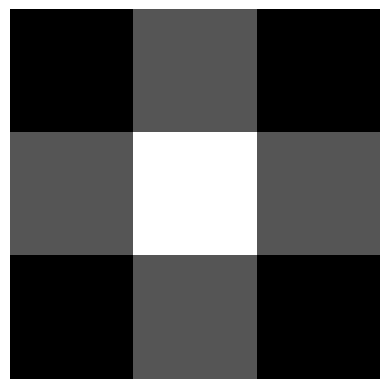

In [113]:
# Create a 3-channel Gaussian kernel
gaussian_filter = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
gau_kernel = np.zeros((3, 3, 3, 3))
for i in range(3):
    gau_kernel[i, i] = gaussian_filter

# Initialize convolution layer
conv_layer = ConvolutionLayer(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
conv_layer.set_weights(gau_kernel)

#visulaze the gaussian filter
plt.imshow(gaussian_filter, cmap='gray')
plt.axis('off')
plt.show()


### Generate output for the first 5 images of the training set

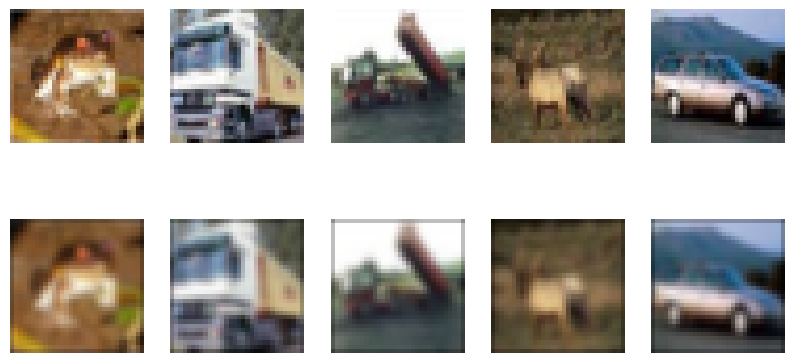

In [114]:
output_images = conv_layer.forward(train_images[:5])

# Display the original and output images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].transpose(1, 2, 0))
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.imshow(output_images[i].transpose(1, 2, 0))
    plt.axis('off')

## Question 5
<br>
Now we will use this module for training a simple Convolution Layer using CIFAR-10 images. 

* The goal is to learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Instantiate a Convolution  layer $C_0$ with 20 filters, each with size 5$\times$5 (RGB image, so 3 input channels). Load the given numpy array of size (20,3,5,5), which represents the weights of a convolution layer. Set the given values as the filter weights for $C_0$. Take 100 CIFAR-10 images. Save the output of these 100 images generated from this Convolution layer $C_0$. 
  
  * Now, initialize a new convolution layer $C$ with weight values sampled from uniform distribution [-1,1]. Use the $L_2$ loss between the output of this layer $C$ and the output generated in the previous step to learn the filter weights of $C_0$.


In [138]:
# ## Load filter weights from given numpy array "C0_weights.npy".
# ## Init a conv layer C_0 with these given weights

# ## For all images get output. Store in numpy array.
# Initialize convolution layers
conv_c0 = ConvolutionLayer(3, 20, 5, stride=1, padding=2)
conv_c = ConvolutionLayer(3, 20, 5, stride=1, padding=2)

# Load and set pre-trained weights
c0_weights = np.load('C0_weights.npy')
conv_c0.set_weights(c0_weights)



In [139]:


class L2Loss:
    def forward(self, pred, target):
        # Normalize loss by the number of elements
        return np.mean((pred - target) ** 2)

    def backward(self, pred, target):
        # Normalize gradient by the number of elements
        return 2 * (pred - target) / np.prod(pred.shape)


# Initialize L2 loss
l2_loss = L2Loss()

# Training parameters
learning_rate = 0.001  # Reduced learning rate
num_epochs = 10
batch_size = 32

# Assuming we have a dataset of images stored in a numpy array `images`

# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        
        # Forward pass through C_0
        output_c0 = conv_c0.forward(batch)
        
        # Forward pass through C
        output_c = conv_c.forward(batch)
        
        # Compute L2 loss
        loss = l2_loss.forward(output_c, output_c0)
        
        # Backward pass
        grad_loss = l2_loss.backward(output_c, output_c0)
        grad_weights, grad_bias = conv_c.backward(grad_loss)
        
        # Update weights
        conv_c.update_weights(grad_weights, grad_bias, learning_rate)
        
        # Print loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i//batch_size+1}/{len(images)//batch_size}], Loss: {loss:.4f}')

# After training, compute the L2 distance between the outputs of C and C_0
output_c0_final = conv_c0.forward(images)
output_c_final = conv_c.forward(images)
l2_distance = np.sqrt(np.mean((output_c_final - output_c0_final) ** 2))

print(f'L2 Distance between outputs of C and C_0: {l2_distance:.4f}')

Epoch [1/10], Batch [1/2], Loss: 7.8541
Epoch [1/10], Batch [2/2], Loss: 8.5464
Epoch [1/10], Batch [3/2], Loss: 8.3749
Epoch [2/10], Batch [1/2], Loss: 7.8511
Epoch [2/10], Batch [2/2], Loss: 8.5430
Epoch [2/10], Batch [3/2], Loss: 8.3716
Epoch [3/10], Batch [1/2], Loss: 7.8480
Epoch [3/10], Batch [2/2], Loss: 8.5397
Epoch [3/10], Batch [3/2], Loss: 8.3684
Epoch [4/10], Batch [1/2], Loss: 7.8450
Epoch [4/10], Batch [2/2], Loss: 8.5363
Epoch [4/10], Batch [3/2], Loss: 8.3651
Epoch [5/10], Batch [1/2], Loss: 7.8420
Epoch [5/10], Batch [2/2], Loss: 8.5329
Epoch [5/10], Batch [3/2], Loss: 8.3618
Epoch [6/10], Batch [1/2], Loss: 7.8390
Epoch [6/10], Batch [2/2], Loss: 8.5296
Epoch [6/10], Batch [3/2], Loss: 8.3586
Epoch [7/10], Batch [1/2], Loss: 7.8360
Epoch [7/10], Batch [2/2], Loss: 8.5262
Epoch [7/10], Batch [3/2], Loss: 8.3553
Epoch [8/10], Batch [1/2], Loss: 7.8329
Epoch [8/10], Batch [2/2], Loss: 8.5229
Epoch [8/10], Batch [3/2], Loss: 8.3521
Epoch [9/10], Batch [1/2], Loss: 7.8299
